In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import time
from datetime import datetime
from torch.utils.data import DataLoader

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
#Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc=nn.Sequential(
        nn.Conv2d(3, 196, kernel_size=3, stride=1, padding=1),
        nn.LayerNorm(normalized_shape=[196, 32, 32]),
        nn.LeakyReLU(),

        nn.Conv2d(196, 196, kernel_size=3, stride=2, padding=1),
        nn.LayerNorm(normalized_shape=[196, 16, 16]),
        nn.LeakyReLU(),

        nn.Conv2d(196, 196, kernel_size=3, stride=1, padding=1),
        nn.LayerNorm(normalized_shape=[196, 16, 16]),
        nn.LeakyReLU(),

        nn.Conv2d(196, 196, kernel_size=3, stride=2, padding=1),
        nn.LayerNorm(normalized_shape=[196, 8, 8]),
        nn.LeakyReLU(),

        nn.Conv2d(196, 196, kernel_size=3, stride=1, padding=1),
        nn.LayerNorm(normalized_shape=[196, 8, 8]),
        nn.LeakyReLU(),

        nn.Conv2d(196, 196, kernel_size=3, stride=1, padding=1),
        nn.LayerNorm(normalized_shape=[196, 8, 8]),
        nn.LeakyReLU(),

        nn.Conv2d(196, 196, kernel_size=3, stride=1, padding=1),
        nn.LayerNorm(normalized_shape=[196, 8, 8]),
        nn.LeakyReLU(),

        nn.Conv2d(196, 196, kernel_size=3, stride=2, padding=1),
        nn.LayerNorm(normalized_shape=[196, 4, 4]),
        nn.LeakyReLU(),

        nn.MaxPool2d(kernel_size=4, stride=4, padding=0),
        
        )
        self.fc1 = nn.Linear(196, 1)
        self.fc10 = nn.Linear(196, 10)
    def forward(self, x):
        x=self.disc(x)
        x = x.view(x.size(0), -1)
        fc1_out = self.fc1(x)
        fc10_out = self.fc10(x)

        return fc1_out,fc10_out

In [4]:
net1 = Discriminator()
# print(net1)

In [5]:
#Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gen=nn.Sequential(
        nn.Linear(100, 196*4*4),
        nn.BatchNorm1d(196*4*4),
        nn.ReLU(),
        )
        self.gen2=nn.Sequential(
        nn.ConvTranspose2d(196, 196, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(196),
        nn.ReLU(),

        nn.Conv2d(196, 196, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(196),
        nn.ReLU(),

        nn.Conv2d(196, 196, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(196),
        nn.ReLU(),

        nn.Conv2d(196, 196, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(196),
        nn.ReLU(),

        nn.ConvTranspose2d(196, 196, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(196),
        nn.ReLU(),

        nn.Conv2d(196, 196, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(196),
        nn.ReLU(),

        nn.ConvTranspose2d(196, 196, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(196),
        nn.ReLU(),

        nn.Conv2d(196, 3, kernel_size=3, stride=1, padding=1),
        # bn and relu are not applied after conv8

        nn.Tanh(),
        )
    def forward(self, x):
        x=self.gen(x)
        x = x.view(-1, 196, 4, 4)
        return self.gen2(x)

    

In [6]:
net2 = Generator()
# # print(net2)
# x = torch.randn(10, 100)
# gen_out = net2(x)

In [7]:
batch_size = 128

learning_rate = 0.0001

In [8]:
import torchvision.transforms as transforms
transform= transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.7, 1.0), ratio=(1.0,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [9]:
trainset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
testset = torchvision.datasets.CIFAR10(root='./', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8)

In [11]:
model =  Discriminator()
model.to(device)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 196, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LayerNorm((196, 32, 32), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(196, 196, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LayerNorm((196, 16, 16), eps=1e-05, elementwise_affine=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(196, 196, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LayerNorm((196, 16, 16), eps=1e-05, elementwise_affine=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(196, 196, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): LayerNorm((196, 8, 8), eps=1e-05, elementwise_affine=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(196, 196, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LayerNorm((196, 8, 8), eps=1e-05, elementwise_affine=True)
    (14): LeakyReLU(negative_slope=0.01)
    (15): Conv2d(196, 196, ke

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
best_accuracy = 0.0


def train(epoch, trainloader):

    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    time1 = time.time()
    for batch_idx, (X_train_batch, Y_train_batch) in enumerate(trainloader):

        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)
        # only need fc10 output
        _, fc10_out = model(X_train_batch)

        loss = criterion(fc10_out, Y_train_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * Y_train_batch.size(0)
        _, predicted = fc10_out.max(1)
        total += Y_train_batch.size(0)
        correct += predicted.eq(Y_train_batch).sum().item()

    total_loss = train_loss / len(trainloader.dataset)
    total_acc = 100.0 * correct / total
    time2 = time.time()
    sec = time2-time1
    min, sec = divmod(sec, 60)
    hr, min = divmod(min, 60)
    print('Epoch: {} | Train Loss: {:.3f} | Train Acc: {:.3f}% | Time: {:.2f} hr {:.2f} min {:.2f} sec'.format(epoch, total_loss, total_acc, hr, min, sec))

In [14]:
ckpt_dir='/kaggle/working/cifar-10-batches-py'
n_epoch = 1

In [15]:
def test(epoch, testloader):
    global best_accuracy

    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    time1 = time.time()
    with torch.no_grad():
        for batch_idx, (X_test_batch, Y_test_batch) in enumerate(testloader):
            X_test_batch = X_test_batch.to(device)
            Y_test_batch = Y_test_batch.to(device)
            # only need fc10 output
            _, fc10_out = model(X_test_batch)

            loss = criterion(fc10_out, Y_test_batch)

            test_loss += loss.item() * Y_test_batch.size(0)
            _, predicted = fc10_out.max(1)
            total += Y_test_batch.size(0)
            correct += predicted.eq(Y_test_batch).sum().item()

    total_loss = test_loss / len(testloader.dataset)
    total_acc = 100.0 * correct / total
    time2 = time.time()
    sec = time2-time1
    min, sec = divmod(sec, 60)
    hr, min = divmod(min, 60)
    print('Epoch: {} | Test Loss: {:.3f} | Test Acc: {:.3f}% | Time: {:.2f} hr {:.2f} min {:.2f} sec'.format(epoch, total_loss, total_acc, hr, min, sec))


In [16]:
for epoch in range(n_epoch):
    train(epoch, trainloader)
    test(epoch, testloader)

Epoch: 0 | Train Loss: 1.609 | Train Acc: 41.274% | Time: 0.00 hr 0.00 min 35.35 sec
Epoch: 0 | Test Loss: 1.362 | Test Acc: 51.010% | Time: 0.00 hr 0.00 min 4.22 sec


In [17]:
batch_size = 128
n_epoch = 60
learning_rate = 0.0002
n_classes = 10
gen_train = 1
n_z= 100  # dim of the random noise vector

In [18]:
# define model
aD =  Discriminator()
aD.cuda()

aG = Generator()
aG.cuda()

optimizer_g = torch.optim.Adam(aG.parameters(), lr=learning_rate, betas=(0, 0.9))
optimizer_d = torch.optim.Adam(aD.parameters(), lr=learning_rate, betas=(0, 0.9))
criterion = nn.CrossEntropyLoss()


In [19]:
import numpy as np
from torch.autograd import Variable
import torch.autograd as autograd
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [20]:
def calc_gradient_penalty(netD, real_data, fake_data):
    DIM = 32
    LAMBDA = 10
    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand(batch_size, int(real_data.nelement()/batch_size)).contiguous()
    alpha = alpha.view(batch_size, 3, DIM, DIM)
    alpha = alpha.cuda()

    fake_data = fake_data.view(batch_size, 3, DIM, DIM)
    interpolates = alpha * real_data.detach() + ((1 - alpha) * fake_data.detach())

    interpolates = interpolates.cuda()
    interpolates.requires_grad_(True)

    disc_interpolates, _ = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
  
    return gradient_penalty

In [21]:
# This function is used to plot a 10 by 10 grid of images scaled between 0 and 1
def plot(samples):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(10, 10)
    gs.update(wspace=0.02, hspace=0.02)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample)
    return fig

In [22]:
def train(trainloader):
    for batch_idx, (X_train_batch, Y_train_batch) in enumerate(trainloader):
        if (Y_train_batch.shape[0] < batch_size):
            continue

        ################## train the Generator ##################
        # the generator is trained every gen_train number of iteration
        # Sometimes the discriminator is trained more frequently than the
        # generator meaning gen_train can be set to something like 5.
        if ((batch_idx % gen_train) == 0):
            # The gradients for the discriminator parameters are turned off
            # during the generator update as this saves GPU memory.
            for p in aD.parameters():
                p.requires_grad_(False)

            aG.zero_grad()

            label = np.random.randint(0, n_classes, batch_size)
            noise = np.random.normal(0, 1, (batch_size, n_z))
            label_onehot = np.zeros((batch_size, n_classes))
            label_onehot[np.arange(batch_size), label] = 1
            noise[np.arange(batch_size), :n_classes] = label_onehot[np.arange(batch_size)]
            noise = noise.astype(np.float32)
            # plt.imshow(noise)
            # plt.show() #working good
            noise = torch.from_numpy(noise)
            noise = Variable(noise).cuda()
            fake_label = Variable(torch.from_numpy(label)).cuda()

            # fake images coming from the generator
            fake_data = aG(noise)
            # gen_source is the value from fc1, gen_class output is from fc10
            gen_source, gen_class = aD(fake_data)

            gen_source = gen_source.mean()
            gen_class = criterion(gen_class, fake_label)

            gen_cost = -gen_source + gen_class
            gen_cost.backward()

            optimizer_g.step()

        ################## train the Discriminator ##################
        # turn on gradient for discriminator, since now we need to update it
        for p in aD.parameters():
            p.requires_grad_(True)

        aD.zero_grad()

        # train discriminator with input from generator
        label = np.random.randint(0, n_classes, batch_size)
        noise = np.random.normal(0, 1, (batch_size, n_z))
        label_onehot = np.zeros((batch_size, n_classes))
        label_onehot[np.arange(batch_size), label] = 1
        noise[np.arange(batch_size), :n_classes] = label_onehot[np.arange(batch_size)]
        noise = noise.astype(np.float32)
        noise = torch.from_numpy(noise)
        noise = Variable(noise).cuda()
        fake_label = Variable(torch.from_numpy(label)).cuda()
        with torch.no_grad():
            fake_data = aG(noise)

        disc_fake_source, disc_fake_class = aD(fake_data)

        disc_fake_source = disc_fake_source.mean()  # fc1 loss
        disc_fake_class = criterion(disc_fake_class, fake_label)  # fc10 loss

        # train discriminator with input from the discriminator
        real_data = Variable(X_train_batch).cuda()
        real_label = Variable(Y_train_batch).cuda()

        disc_real_source, disc_real_class = aD(real_data)

        prediction = disc_real_class.data.max(1)[1]
        accuracy = (float(prediction.eq(real_label.data).sum()) / float(batch_size)) * 100.0

        disc_real_source = disc_real_source.mean()  # fc1 loss
        disc_real_class = criterion(disc_real_class, real_label)  # fc10 loss
        #print(real_data,fake_data)
        gradient_penalty = calc_gradient_penalty(aD, real_data, fake_data)
        # print(gradient_penalty)

        disc_cost = disc_fake_source - disc_real_source + disc_real_class + disc_fake_class + gradient_penalty
        disc_cost.backward()

        optimizer_d.step()

In [23]:
def test(testloader):
    # Test the model
    aD.eval()

    with torch.no_grad():
        test_accu = []
        for batch_idx, (X_test_batch, Y_test_batch) in enumerate(testloader):
            X_test_batch, Y_test_batch = Variable(X_test_batch).cuda(), Variable(Y_test_batch).cuda()

            with torch.no_grad():
                _, output = aD(X_test_batch)

            prediction = output.data.max(1)[1]  # first column has actual prob.
            accuracy = (float(prediction.eq(Y_test_batch.data).sum()) / float(batch_size)) * 100.0
            test_accu.append(accuracy)
            accuracy_test = np.mean(test_accu)

    return accuracy_test

In [24]:
np.random.seed(352)
label = np.asarray(list(range(10))*10)
# print(label)
noise = np.random.normal(0,1,(100, n_z))  # 100x100 random noise 0-1
# print(n_z,"n_Z")
label_onehot = np.zeros((100,n_classes))
# print(label_onehot)
label_onehot[np.arange(100), label] = 1  # 100x10 one hot label, each row one label
# each row is a 100 dim vector that will be transformed into fake image
# set first 10 number of each row as one hot label
noise[np.arange(100), :n_classes] = label_onehot[np.arange(100)]
noise = noise.astype(np.float32)
# print(noise)
# print(noise.shape)


In [25]:
import matplotlib.pyplot as plt

# plt.imshow(noise)
# plt.show()
save_noise = torch.from_numpy(noise)
save_noise = Variable(save_noise).cuda()

In [26]:
out_dir='/kaggle/working/cifar-10-batches-py'

Epoch: 0 | Test Acc: 26.028% | Time: 0.00 hr 3.00 min 19.01 sec


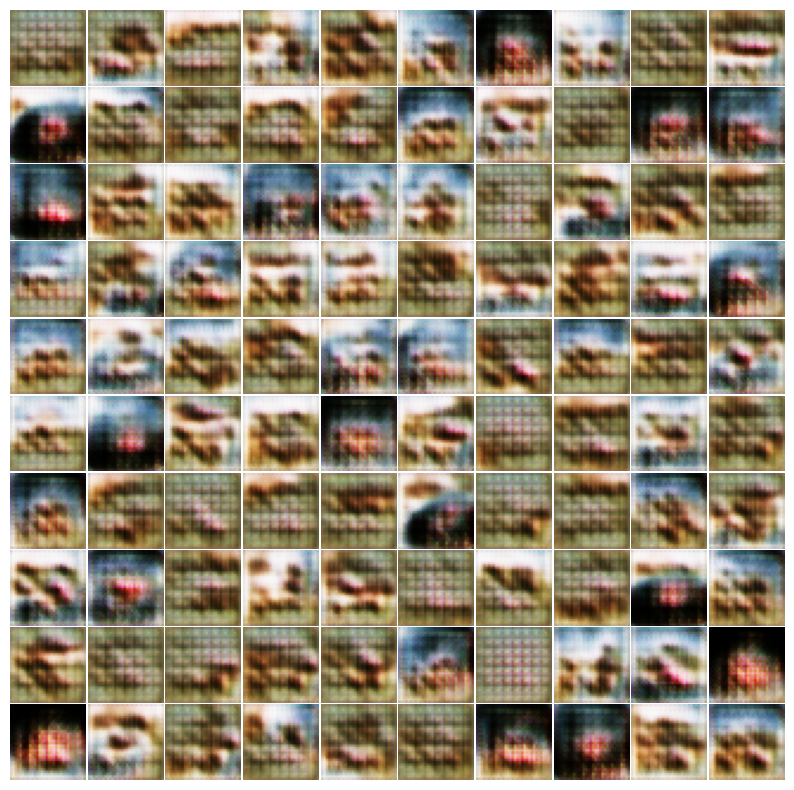

Epoch: 1 | Test Acc: 36.106% | Time: 0.00 hr 3.00 min 18.97 sec
Epoch: 2 | Test Acc: 38.410% | Time: 0.00 hr 3.00 min 18.76 sec
Epoch: 3 | Test Acc: 39.438% | Time: 0.00 hr 3.00 min 18.88 sec
Epoch: 4 | Test Acc: 44.244% | Time: 0.00 hr 3.00 min 19.08 sec
Epoch: 5 | Test Acc: 46.905% | Time: 0.00 hr 3.00 min 18.91 sec
Epoch: 6 | Test Acc: 49.169% | Time: 0.00 hr 3.00 min 18.41 sec
Epoch: 7 | Test Acc: 49.080% | Time: 0.00 hr 3.00 min 19.00 sec
Epoch: 8 | Test Acc: 48.052% | Time: 0.00 hr 3.00 min 18.44 sec
Epoch: 9 | Test Acc: 52.858% | Time: 0.00 hr 3.00 min 18.66 sec
Epoch: 10 | Test Acc: 52.739% | Time: 0.00 hr 3.00 min 18.61 sec
Epoch: 11 | Test Acc: 53.254% | Time: 0.00 hr 3.00 min 18.64 sec
Epoch: 12 | Test Acc: 56.883% | Time: 0.00 hr 3.00 min 18.60 sec
Epoch: 13 | Test Acc: 58.416% | Time: 0.00 hr 3.00 min 18.53 sec
Epoch: 14 | Test Acc: 57.684% | Time: 0.00 hr 3.00 min 19.18 sec
Epoch: 15 | Test Acc: 57.110% | Time: 0.00 hr 3.00 min 18.69 sec


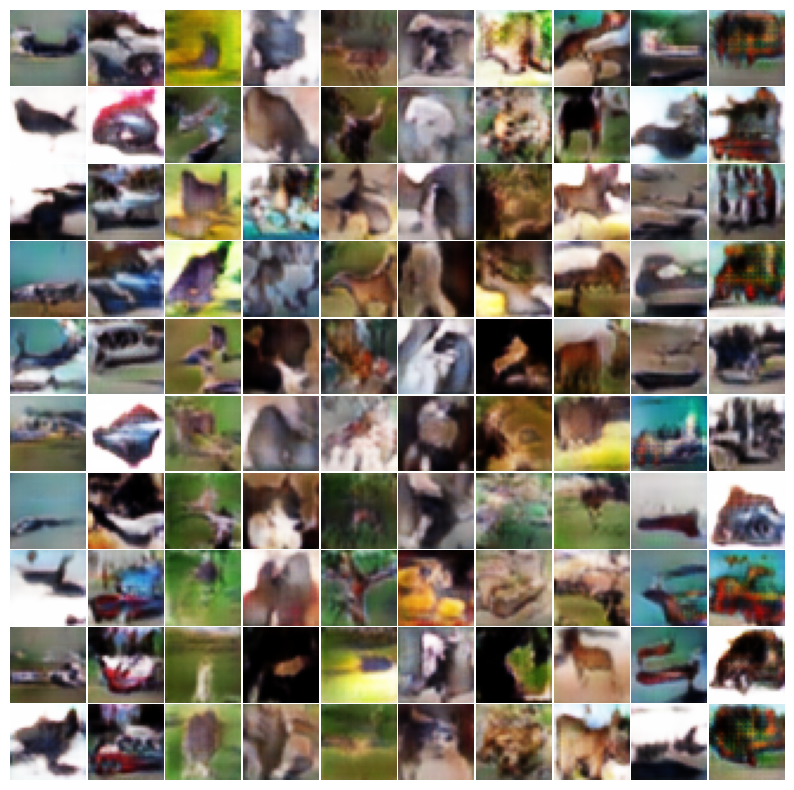

Epoch: 16 | Test Acc: 61.392% | Time: 0.00 hr 3.00 min 18.13 sec
Epoch: 17 | Test Acc: 62.530% | Time: 0.00 hr 3.00 min 19.34 sec
Epoch: 18 | Test Acc: 61.452% | Time: 0.00 hr 3.00 min 18.80 sec
Epoch: 19 | Test Acc: 63.123% | Time: 0.00 hr 3.00 min 18.76 sec
Epoch: 20 | Test Acc: 63.588% | Time: 0.00 hr 3.00 min 19.02 sec
Epoch: 21 | Test Acc: 64.310% | Time: 0.00 hr 3.00 min 18.67 sec
Epoch: 22 | Test Acc: 65.061% | Time: 0.00 hr 3.00 min 18.89 sec
Epoch: 23 | Test Acc: 65.645% | Time: 0.00 hr 3.00 min 18.85 sec
Epoch: 24 | Test Acc: 66.515% | Time: 0.00 hr 3.00 min 19.51 sec
Epoch: 25 | Test Acc: 65.516% | Time: 0.00 hr 3.00 min 18.80 sec
Epoch: 26 | Test Acc: 65.526% | Time: 0.00 hr 3.00 min 18.65 sec
Epoch: 27 | Test Acc: 66.278% | Time: 0.00 hr 3.00 min 19.02 sec
Epoch: 28 | Test Acc: 66.149% | Time: 0.00 hr 3.00 min 19.02 sec
Epoch: 29 | Test Acc: 67.534% | Time: 0.00 hr 3.00 min 18.88 sec
Epoch: 30 | Test Acc: 67.563% | Time: 0.00 hr 3.00 min 18.62 sec


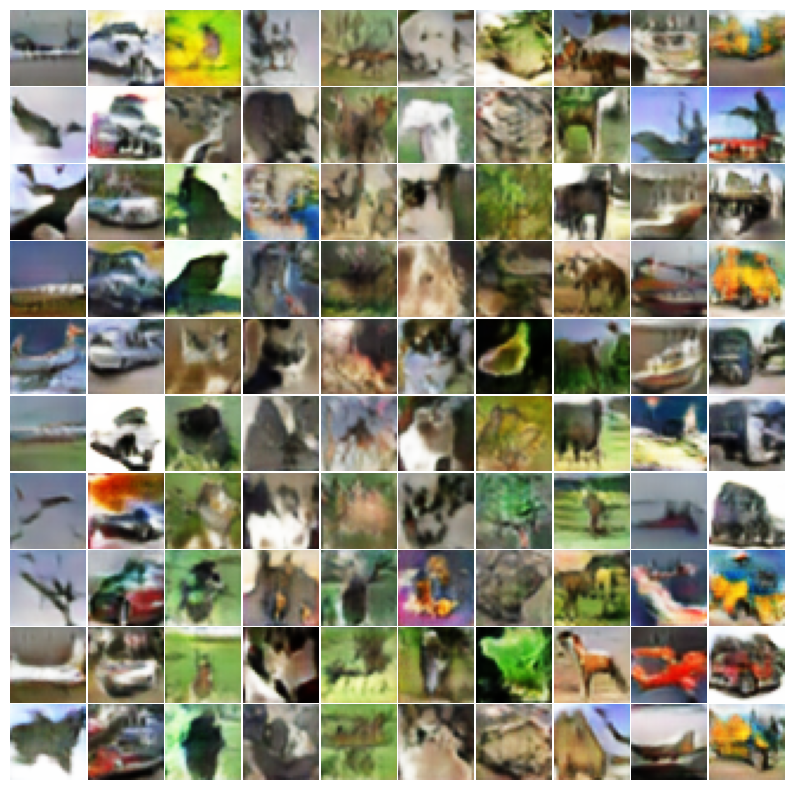

Epoch: 31 | Test Acc: 68.483% | Time: 0.00 hr 3.00 min 19.41 sec
Epoch: 32 | Test Acc: 69.294% | Time: 0.00 hr 3.00 min 18.77 sec
Epoch: 33 | Test Acc: 68.740% | Time: 0.00 hr 3.00 min 18.69 sec
Epoch: 34 | Test Acc: 69.393% | Time: 0.00 hr 3.00 min 18.92 sec
Epoch: 35 | Test Acc: 70.045% | Time: 0.00 hr 3.00 min 18.68 sec
Epoch: 36 | Test Acc: 68.384% | Time: 0.00 hr 3.00 min 18.67 sec
Epoch: 37 | Test Acc: 70.283% | Time: 0.00 hr 3.00 min 19.44 sec
Epoch: 38 | Test Acc: 70.016% | Time: 0.00 hr 3.00 min 18.59 sec
Epoch: 39 | Test Acc: 69.393% | Time: 0.00 hr 3.00 min 18.49 sec
Epoch: 40 | Test Acc: 70.491% | Time: 0.00 hr 3.00 min 18.60 sec
Epoch: 41 | Test Acc: 69.689% | Time: 0.00 hr 3.00 min 18.69 sec
Epoch: 42 | Test Acc: 70.758% | Time: 0.00 hr 3.00 min 18.94 sec
Epoch: 43 | Test Acc: 70.589% | Time: 0.00 hr 3.00 min 18.82 sec
Epoch: 44 | Test Acc: 70.936% | Time: 0.00 hr 3.00 min 19.26 sec
Epoch: 45 | Test Acc: 71.361% | Time: 0.00 hr 3.00 min 18.63 sec


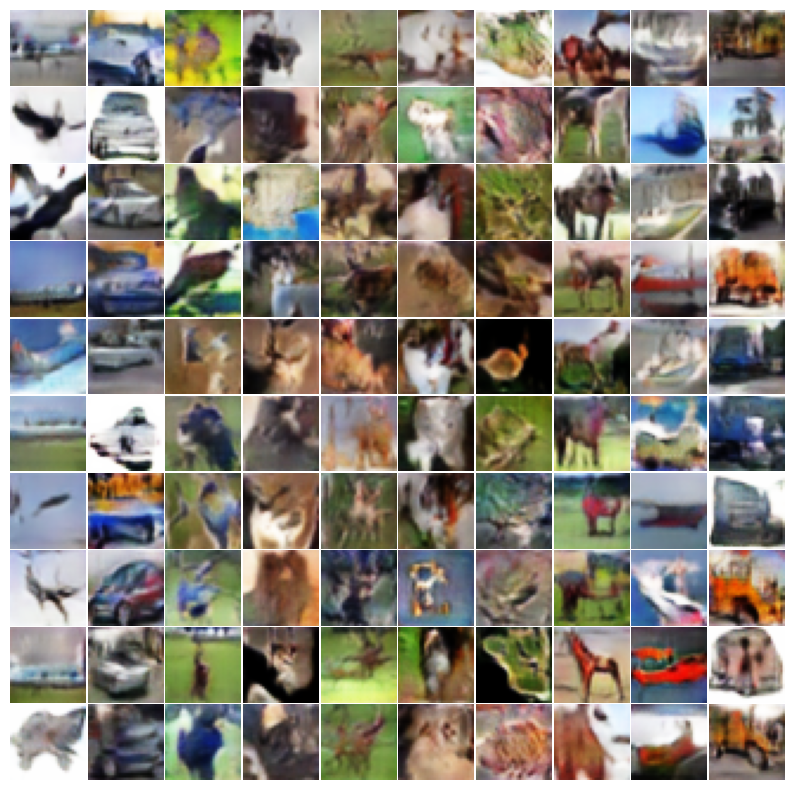

Epoch: 46 | Test Acc: 71.568% | Time: 0.00 hr 3.00 min 18.31 sec
Epoch: 47 | Test Acc: 71.756% | Time: 0.00 hr 3.00 min 19.25 sec
Epoch: 48 | Test Acc: 72.073% | Time: 0.00 hr 3.00 min 18.66 sec
Epoch: 49 | Test Acc: 72.251% | Time: 0.00 hr 3.00 min 18.57 sec
Epoch: 50 | Test Acc: 72.053% | Time: 0.00 hr 3.00 min 18.91 sec
Epoch: 51 | Test Acc: 71.806% | Time: 0.00 hr 3.00 min 19.12 sec
Epoch: 52 | Test Acc: 72.191% | Time: 0.00 hr 3.00 min 18.81 sec
Epoch: 53 | Test Acc: 71.845% | Time: 0.00 hr 3.00 min 18.59 sec
Epoch: 54 | Test Acc: 71.677% | Time: 0.00 hr 3.00 min 19.21 sec
Epoch: 55 | Test Acc: 72.676% | Time: 0.00 hr 3.00 min 19.02 sec
Epoch: 56 | Test Acc: 72.528% | Time: 0.00 hr 3.00 min 18.81 sec
Epoch: 57 | Test Acc: 72.231% | Time: 0.00 hr 3.00 min 19.51 sec
Epoch: 58 | Test Acc: 73.210% | Time: 0.00 hr 3.00 min 18.86 sec
Epoch: 59 | Test Acc: 72.350% | Time: 0.00 hr 3.00 min 18.92 sec


In [27]:


for epoch in range(n_epoch):

    # turn model to train mode
    aG.train()
    aD.train()

    time1 = time.time()
    train(trainloader)
    accuracy_test = test(testloader)
    time2 = time.time()

    sec = time2-time1
    min, sec = divmod(sec, 60)
    hr, min = divmod(min, 60)
    print('Epoch: {} | Test Acc: {:.3f}% | Time: {:.2f} hr {:.2f} min {:.2f} sec'.format(epoch, accuracy_test, hr, min, sec))

    # generate images using save_noise created before training
    with torch.no_grad():
        aG.eval()
        samples = aG(save_noise)
        samples = samples.data.cpu().numpy()
        samples += 1.0
        samples /= 2.0
        samples = samples.transpose(0, 2, 3, 1)
        aG.train()

#     fig = plot(samples)
#     # plt.imshow(fig)
    
# #     plt.savefig(out_dir + '/%s.png' % str(epoch).zfill(3), bbox_inches='tight')
#     plt.show()
#     plt.close(fig)

    if (((epoch) % 15) == 0):
        fig = plot(samples)
        plt.show()
        plt.close(fig)
        for param_group in optimizer_d.param_groups:
            param_group['lr']/=2
        for param_group in optimizer_g.param_groups:
            param_group['lr']/=2